### Pharmacutical Company / Lobby Relationship

- this notebook is supposed to look at the relationship between the amount of Medicare money a pharmacutical company receives in a year compared to the total expenditure on lobbying by that company (datasets are merged by a sort of fuzzy string matching --- I really only looked at the top 10 or 15 pharmacutical companies as well, I didn't quite have time to look at and try to match every single one) All data taken from https://data.world/data4democracy/drug-spending

- coding done by Geoff Perrin (https://github.com/gperrin12) during the Data4Democracy Hackathon, 4-1-17

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.max_columns = 120

In [2]:
### list of additional pharma companies that I try to fuzzy match on:
pharma_list = ['Solstice', 'Impax', 'AstraZeneca', 'Sanofi', 'Teva', 'Gilead', 'Bayer', 'Summers', 'Abbott']

In [3]:
drug_uses = pd.read_csv('data/drug_uses.csv')
drug_uses.head()

,Unnamed: 0,drugname_brand,drugname_generic,anatomical,therapeutic,pharmacologic,chemical,substance,name
0,0,8-MOP,METHOXSALEN,DERMATOLOGICALS,ANTIPSORIATICS,ANTIPSORIATICS FOR TOPICAL USE,PSORALENS FOR TOPICAL USE,METHOXSALEN,METHOXSALEN
1,1,8-MOP,METHOXSALEN,DERMATOLOGICALS,ANTIPSORIATICS,ANTIPSORIATICS FOR SYSTEMIC USE,PSORALENS FOR SYSTEMIC USE,METHOXSALEN,METHOXSALEN
2,2,OXSORALEN,METHOXSALEN,DERMATOLOGICALS,ANTIPSORIATICS,ANTIPSORIATICS FOR TOPICAL USE,PSORALENS FOR TOPICAL USE,METHOXSALEN,METHOXSALEN
3,3,OXSORALEN,METHOXSALEN,DERMATOLOGICALS,ANTIPSORIATICS,ANTIPSORIATICS FOR SYSTEMIC USE,PSORALENS FOR SYSTEMIC USE,METHOXSALEN,METHOXSALEN
4,4,ABILIFY,ARIPIPRAZOLE,NERVOUS SYSTEM,PSYCHOLEPTICS,ANTIPSYCHOTICS,OTHER ANTIPSYCHOTICS,ARIPIPRAZOLE,ARIPIPRAZOLE


In [4]:
df_nda = pd.read_csv('data/FDA_NDC_Product.csv')
df_nda['NONPROPRIETARYNAME'] = df_nda['NONPROPRIETARYNAME'].apply( lambda x: str(x).upper())
df_nda.head(5)

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE
0,0002-1200_e62214a4-82fd-4e06-90a0-577a32fea93f,0002-1200,HUMAN PRESCRIPTION DRUG,Amyvid,NaN,FLORBETAPIR F 18,"INJECTION, SOLUTION",INTRAVENOUS,20120601.0,NaN,NDA,NDA202008,Eli Lilly and Company,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",NaN
1,0002-1407_e7af3676-cd9d-4c30-b127-9f6c46ff1589,0002-1407,HUMAN PRESCRIPTION DRUG,Quinidine Gluconate,NaN,QUINIDINE GLUCONATE,SOLUTION,INTRAVENOUS,19510301.0,NaN,NDA,NDA007529,Eli Lilly and Company,QUINIDINE GLUCONATE,80,mg/mL,"Antiarrhythmic [EPC],Cytochrome P450 2D6 Inhib...",NaN
2,0002-1433_a084daa7-c0a0-4996-9fe0-3c1df22c01c7,0002-1433,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,DULAGLUTIDE,"INJECTION, SOLUTION",SUBCUTANEOUS,20141107.0,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,0.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN
3,0002-1434_a084daa7-c0a0-4996-9fe0-3c1df22c01c7,0002-1434,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,DULAGLUTIDE,"INJECTION, SOLUTION",SUBCUTANEOUS,20141107.0,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN
4,0002-1445_ad2261c2-3be8-4add-8274-0cc565d86ffb,0002-1445,HUMAN PRESCRIPTION DRUG,TALTZ,NaN,IXEKIZUMAB,"INJECTION, SOLUTION",SUBCUTANEOUS,20160322.0,NaN,BLA,BLA125521,Eli Lilly and Company,IXEKIZUMAB,80,mg/mL,"Interleukin-17A Antagonist [EPC],Interleukin-1...",NaN


In [5]:
df_generic_to_use = df_nda[['NONPROPRIETARYNAME','PHARM_CLASSES', 'LABELERNAME']].drop_duplicates()
df_generic_to_use.head()

,NONPROPRIETARYNAME,PHARM_CLASSES,LABELERNAME
0,FLORBETAPIR F 18,"Radioactive Diagnostic Agent [EPC],Positron Em...",Eli Lilly and Company
1,QUINIDINE GLUCONATE,"Antiarrhythmic [EPC],Cytochrome P450 2D6 Inhib...",Eli Lilly and Company
2,DULAGLUTIDE,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",Eli Lilly and Company
4,IXEKIZUMAB,"Interleukin-17A Antagonist [EPC],Interleukin-1...",Eli Lilly and Company
5,TESTOSTERONE,"Androgen [EPC],Androgen Receptor Agonists [MoA...",Eli Lilly and Company


In [6]:
df_part_d = pd.read_csv('data/Medicare_Drug_Spending_PartD_All_Drugs_YTD_2015_12_06_2016/Data-Table 1.csv')
df_part_d.head()

,Brand Name,Generic Name,"Claim Count, 2011","Total Spending, 2011","Beneficiary Count, 2011","Total Annual Spending Per User, 2011","Unit Count, 2011","Average Cost Per Unit (Weighted), 2011","Beneficiary Count No LIS, 2011","Average Beneficiary Cost Share No LIS, 2011","Beneficiary Count LIS, 2011","Average Beneficiary Cost Share LIS, 2011","Claim Count, 2012","Total Spending, 2012","Beneficiary Count, 2012","Total Annual Spending Per User, 2012","Unit Count, 2012","Average Cost Per Unit (Weighted), 2012","Beneficiary Count No LIS, 2012","Average Beneficiary Cost Share No LIS, 2012","Beneficiary Count LIS, 2012","Average Beneficiary Cost Share LIS, 2012","Claim Count, 2013","Total Spending, 2013","Beneficiary Count, 2013","Total Annual Spending Per User, 2013","Unit Count, 2013","Average Cost Per Unit (Weighted), 2013","Beneficiary Count No LIS, 2013","Average Beneficiary Cost Share No LIS, 2013","Beneficiary Count LIS, 2013","Average Beneficiary Cost Share LIS, 2013","Claim Count, 2014","Total Spending, 2014","Beneficiary Count, 2014","Total Annual Spending Per User, 2014","Unit Count, 2014","Average Cost Per Unit (Weighted), 2014","Beneficiary Count No LIS, 2014","Average Beneficiary Cost Share No LIS, 2014","Beneficiary Count LIS, 2014","Average Beneficiary Cost Share LIS, 2014","Claim Count, 2015","Total Spending, 2015","Beneficiary Count, 2015","Total Annual Spending Per User, 2015","Unit Count, 2015","Average Cost Per Unit (Weighted), 2015","Beneficiary Count No LIS, 2015","Average Beneficiary Cost Share No LIS, 2015","Beneficiary Count LIS, 2015","Average Beneficiary Cost Share LIS, 2015","Annual Change in Average Cost Per Unit, 2015"
0,10 WASH,SULFACETAMIDE SODIUM,24.0,"$1,569.19",16.0,$98.07,5170.0,$0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1ST TIER UNIFINE PENTIPS,"PEN NEEDLE, DIABETIC",2472.0,"$57,666.73",893.0,$64.58,293160.0,$0.20,422.0,$42.35,471.0,$7.55,3486.0,"$75,786.01",1261.0,$60.10,405484.0,$0.19,607.0,$38.24,654.0,$6.50,4413.0,"$95,304.09",1633.0,$58.36,522780.0,$0.18,833.0,$35.62,800.0,$5.88,6788.0,"$150,749.66",2769.0,$54.44,813255.0,$0.19,1481.0,$32.14,1288.0,$5.13,10749.0,"$257,895.63",5173.0,$49.85,1335132.0,$0.19,2878.0,$27.31,2295.0,$3.99,2%
2,1ST TIER UNIFINE PENTIPS PLUS,"PEN NEEDLE, DIABETIC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1137.0,"$27,282.97",619.0,$44.08,137290.0,$0.20,313.0,$23.87,306.0,$2.62,2943.0,"$73,396.65",1470.0,$49.93,369886.0,$0.20,710.0,$28.07,760.0,$3.51,NaN
3,60PSE-400GFN-20DM,GUAIFENESIN/DM/PSEUDOEPHEDRINE,12.0,$350.10,11.0,$31.83,497.0,$0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8-MOP,METHOXSALEN,11.0,"$9,003.26",NaN,NaN,298.0,$30.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,"$19,590.75",NaN,NaN,750.0,$26.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_part_d['Generic Name'] = df_part_d['Generic Name'].apply(lambda x: x.strip())
df_part_d['Generic Name'] = df_part_d['Generic Name'].apply(lambda x: x.replace('HCL','HYDROCHLORIDE'))
df_part_d['Generic Name'] = df_part_d['Generic Name'].apply(lambda x: x.replace('PHOSP','PHOSPHATE'))

In [8]:
df = pd.merge(left = df_part_d, right = df_generic_to_use,how='left',left_on='Generic Name',right_on='NONPROPRIETARYNAME')

In [9]:
df.sort_values(by='PHARM_CLASSES',inplace = True)
df.drop_duplicates(subset = ['Brand Name','Generic Name'],inplace=True)
df.head()

,Brand Name,Generic Name,"Claim Count, 2011","Total Spending, 2011","Beneficiary Count, 2011","Total Annual Spending Per User, 2011","Unit Count, 2011","Average Cost Per Unit (Weighted), 2011","Beneficiary Count No LIS, 2011","Average Beneficiary Cost Share No LIS, 2011","Beneficiary Count LIS, 2011","Average Beneficiary Cost Share LIS, 2011","Claim Count, 2012","Total Spending, 2012","Beneficiary Count, 2012","Total Annual Spending Per User, 2012","Unit Count, 2012","Average Cost Per Unit (Weighted), 2012","Beneficiary Count No LIS, 2012","Average Beneficiary Cost Share No LIS, 2012","Beneficiary Count LIS, 2012","Average Beneficiary Cost Share LIS, 2012","Claim Count, 2013","Total Spending, 2013","Beneficiary Count, 2013","Total Annual Spending Per User, 2013","Unit Count, 2013","Average Cost Per Unit (Weighted), 2013","Beneficiary Count No LIS, 2013","Average Beneficiary Cost Share No LIS, 2013","Beneficiary Count LIS, 2013","Average Beneficiary Cost Share LIS, 2013","Claim Count, 2014","Total Spending, 2014","Beneficiary Count, 2014","Total Annual Spending Per User, 2014","Unit Count, 2014","Average Cost Per Unit (Weighted), 2014","Beneficiary Count No LIS, 2014","Average Beneficiary Cost Share No LIS, 2014","Beneficiary Count LIS, 2014","Average Beneficiary Cost Share LIS, 2014","Claim Count, 2015","Total Spending, 2015","Beneficiary Count, 2015","Total Annual Spending Per User, 2015","Unit Count, 2015","Average Cost Per Unit (Weighted), 2015","Beneficiary Count No LIS, 2015","Average Beneficiary Cost Share No LIS, 2015","Beneficiary Count LIS, 2015","Average Beneficiary Cost Share LIS, 2015","Annual Change in Average Cost Per Unit, 2015",NONPROPRIETARYNAME,PHARM_CLASSES,LABELERNAME
68599,ZYFLO CR,ZILEUTON,7478.0,"$5,142,822.20",1750.0,"$2,938.76",945360.0,$5.44,817.0,$503.21,933.0,$16.47,7687.0,"$9,477,538.42",1734.0,"$5,465.71",989350.0,$9.58,850.0,$655.75,884.0,$13.66,7413.0,"$15,162,169.97",1621.0,"$9,353.59",1045439.0,$14.50,904.0,$709.69,717.0,$17.61,6409.0,"$16,833,688.91",1291.0,"$13,039.26",913912.0,$18.42,717.0,$920.59,574.0,$13.95,5188.0,"$17,740,462.32",1042.0,"$17,025.40",722507.0,$24.55,576.0,"$1,174.86",466.0,$17.85,33%,ZILEUTON,"5-Lipoxygenase Inhibitor [EPC],5-Lipoxygenase ...","Chiesi USA, Inc."
68598,ZYFLO,ZILEUTON,484.0,"$263,295.66",200.0,"$1,316.48",52467.0,$5.02,86.0,$308.68,114.0,$7.96,623.0,"$670,324.20",182.0,"$3,683.10",68142.0,$9.84,94.0,$383.22,88.0,$7.90,676.0,"$1,158,369.46",209.0,"$5,542.44",79261.0,$14.61,113.0,$441.13,96.0,$10.50,784.0,"$1,812,724.81",225.0,"$8,056.55",98751.0,$18.36,106.0,$530.62,119.0,$11.14,1256.0,"$4,051,932.65",423.0,"$9,579.04",165334.0,$24.51,230.0,$442.61,193.0,$5.56,NaN,ZILEUTON,"5-Lipoxygenase Inhibitor [EPC],5-Lipoxygenase ...","Aristos Phamaceuticals, Inc."
52026,PROSCAR,FINASTERIDE,5398.0,"$799,595.53",1466.0,$545.43,247916.0,$3.23,949.0,$246.33,517.0,$12.59,4910.0,"$778,192.19",1217.0,$639.43,236439.0,$3.29,835.0,$260.09,382.0,$14.74,6289.0,"$1,207,369.88",1556.0,$775.94,366145.0,$3.30,1376.0,$171.42,180.0,$14.06,6050.0,"$1,261,118.10",1470.0,$857.90,372196.0,$3.39,1300.0,$167.24,170.0,$15.28,5529.0,"$1,226,545.22",1340.0,$915.33,344600.0,$3.56,1197.0,$153.86,143.0,$13.30,5%,FINASTERIDE,"5-alpha Reductase Inhibitor [EPC],5-alpha Redu...",McKesson Packaging Services Business Unit of M...
5378,AVODART,DUTASTERIDE,1631984.0,"$252,973,207.62",300083.0,$843.01,68997485.0,$3.67,200809.0,$270.09,99274.0,$25.87,1533625.0,"$262,661,376.67",279995.0,$938.09,67098537.0,$3.91,190250.0,$283.40,89745.0,$23.85,1597133.0,"$304,093,064.08",293723.0,"$1,035.31",81127287.0,$3.75,209863.0,$287.32,83860.0,$24.26,1494976.0,"$318,321,406.11",277616.0,"$1,146.62",69313927.0,$4.59,200416.0,$297.69,77200.0,$23.14,1044439.0,"$252,585,668.54",222735.0,"$1,134.02",48400878.0,$5.22,157929.0,$282.78,64806.0,$20.28,14%,DUTASTERIDE,"5-alpha Reductase Inhibitor [EPC],5-alpha Redu...","Actavis Pharma, Inc."
51872,PROPECIA,FINASTERIDE,475.0,"$49,160.14",107.0,$459.44,22591.0,$2.18,NaN,NaN,NaN,

In [10]:
df['PHARM_CLASSES'].fillna('Unknown',inplace=True)

In [11]:
df_spending = df[['Brand Name', 'Generic Name', 'Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015', 'PHARM_CLASSES', 'LABELERNAME']]

#convert spending columns to numeric; those with $ are considered strings
for i in range(2011, 2016):
    df_spending['Total Spending, '+str(i)] = df_spending['Total Spending, '+str(i)].str.replace(',', '')
    df_spending['Total Spending, '+str(i)] = df_spending['Total Spending, '+str(i)].str.replace('$', '')

df_spending[['Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015']] = df_spending[['Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015']].apply(pd.to_numeric)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [12]:
grouped = df_spending.groupby(['LABELERNAME'], as_index=False)['Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015'].sum()


In [13]:
grouped['pharma_name']=''
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Pfizer")] = 'Pfizer'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Bristol")] = 'Bristol-Myers Squibb'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Lilly")] = 'Eli Lilly & Co'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Glaxo")] = 'GlaxoSmithKline'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Kline")] = 'GlaxoSmithKline'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Johnson")] = 'Johnson & Johnson'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Merck")] = 'Merck & Co'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Novartis")] = 'Novartis'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Allergan")] = 'Allergan'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Actavis")] = 'Allergan'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Mckesson")] = 'Mckesson'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Aristos")] = 'Aristos'
grouped['pharma_name'][grouped['LABELERNAME'].str.contains("Chiesi")] = 'Chiesi'

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geoffperrin/anaconda2/lib/python2.7/

In [14]:
### perform additional fuzzy matching on pharma name
for i in pharma_list:
    grouped['pharma_name'][grouped['LABELERNAME'].str.contains(i)] = i

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
company_total = grouped.groupby(['pharma_name'], as_index=False)['Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015'].sum()

In [16]:
#pd.melt(df, id_vars=['A'], value_vars=['B', 'C'])
company_total_long = pd.melt(company_total, id_vars=['pharma_name'], value_vars=['Total Spending, 2011', 'Total Spending, 2012', 'Total Spending, 2013',\
                 'Total Spending, 2014', 'Total Spending, 2015'])

In [17]:
company_total_long['variable'] = company_total_long['variable'].str.replace('Total Spending, ', '')
company_total_long.columns = ['pharma_name', 'year', 'total_medicare_billing']
company_total_long['year'] = company_total_long['year'].astype(str)

In [18]:
data_folder = '/Users/geoffperrin/Desktop/Data4Democracy/drug-spending/python/timeseries_analysis/data'

In [19]:
pharma_lobby = pd.read_csv(data_folder + '/Pharma_Lobby.csv')
pharma_lobby = pharma_lobby[['client', 'sub', 'total', 'year']]
pharma_lobby.head(5)

,client,sub,total,year
0,SmithKline Beecham,SmithKline Beecham,2680000.0,1998
1,Hoechst Corp,Hoechst Marion Roussel,840000.0,1998
2,Glaxo Wellcome Inc,Glaxo Wellcome Inc,3120000.0,1998
3,GlaxoSmithKline,GlaxoSmithKline,4860000.0,2005
4,GlaxoSmithKline,GlaxoSmithKline,4920000.0,2012


In [20]:
dates = pd.date_range('1998', '2015', freq='A')

In [21]:
df_dates = pd.DataFrame(dates.year)
df_dates.columns = ['year']

In [22]:
pharma_lobby_dates = df_dates.merge(pharma_lobby, on='year', how='left')
pharma_lobby_dates.head()

,year,client,sub,total
0,1998,SmithKline Beecham,SmithKline Beecham,2680000.0
1,1998,Hoechst Corp,Hoechst Marion Roussel,840000.0
2,1998,Glaxo Wellcome Inc,Glaxo Wellcome Inc,3120000.0
3,1998,Bristol-Myers Squibb,Bristol-Myers Squibb,2820579.0
4,1998,GlaxoSmithKline,GlaxoSmithKline,220000.0


In [23]:
pharma_lobby_dates['pharma_name']=''
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Pfizer")] = 'Pfizer'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Bristol")] = 'Bristol-Myers Squibb'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Lilly")] = 'Eli Lilly & Co'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Glaxo")] = 'GlaxoSmithKline'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Kline")] = 'GlaxoSmithKline'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Johnson")] = 'Johnson & Johnson'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Merck")] = 'Merck & Co'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Novartis")] = 'Novartis'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Allergan")] = 'Allergan'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Actavis")] = 'Allergan'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Mckesson")] = 'Mckesson'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Aristos")] = 'Aristos'
pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains("Chiesi")] = 'Chiesi'

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geoffperrin/anaconda2/lib/python2.7/

In [24]:
### perform additional fuzzy matching on pharma name
for i in pharma_list:
    pharma_lobby_dates['pharma_name'][pharma_lobby_dates['client'].str.contains(i)] = i

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Check out the top 50 pharmas, not aggregated to pharma_name

In [25]:
#take top 50 pharmas
pharma_totals = pharma_lobby_dates.groupby(by='client', as_index=False)['client', 'total'].sum()
pharma_totals.sort_values(['total'], inplace=True, ascending=False)
top_50_pharmas = pharma_totals['client'].head(15)

In [26]:
pharma_lobby_dates_50 = pharma_lobby_dates[pharma_lobby_dates['client'].isin(top_50_pharmas)]
pharma_lobby_dates_50 = pharma_lobby_dates_50.groupby(by=['client', 'year'], as_index=False)['year', 'client', 'total'].sum()

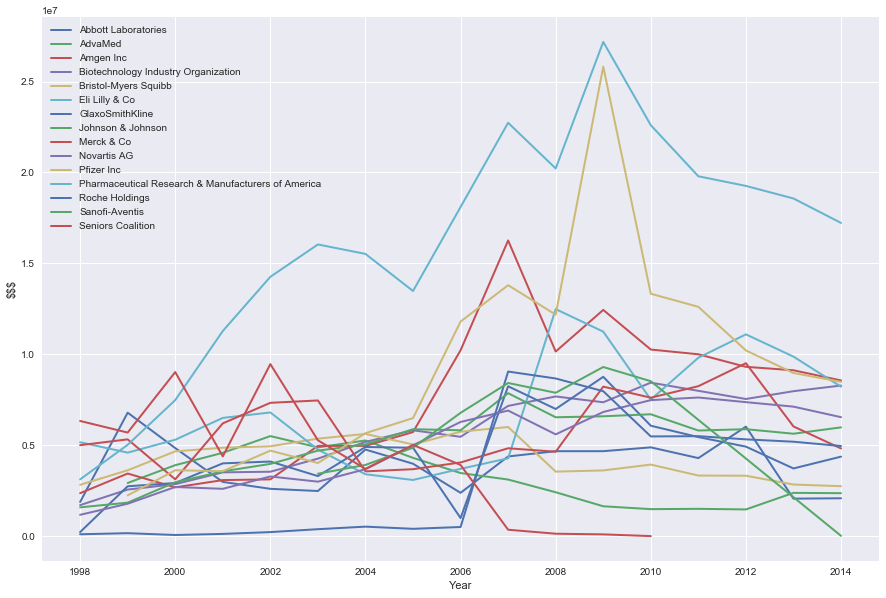

In [27]:
plt.figure(figsize=(15,10))
for i in pharma_lobby_dates_50.client.unique():
    df = pharma_lobby_dates_50[pharma_lobby_dates_50['client']==i]
    name = i
    plt.plot(df.year, df.total, linewidth=2.0, label=name)
    plt.ylabel('$$$')
    plt.xlabel('Year')
    #plt.title('MTA Ridership (Top 4 52-week Periodicity Stations) Total Weekly Ridership Chart')
    plt.legend()
    
plt.show()

### Check top pharma_names lobby $$$

In [28]:
pharma_lobby_agg = pharma_lobby_dates.groupby(by=['pharma_name', 'year'], as_index=False)['pharma_name', 'total'].sum()
pharma_lobby_agg.columns = ['pharma_name', 'year', 'lobby_spending']
pharma_lobby_agg['year'] = pharma_lobby_agg['year'].astype(str)

In [29]:
pharma_medicare_plus_lobby = pharma_lobby_agg.merge(company_total_long, on=['pharma_name', 'year'])
pharma_medicare_plus_lobby = pharma_medicare_plus_lobby[pharma_medicare_plus_lobby['pharma_name']!='']

In [30]:
pharma_medicare_plus_lobby['log_lobby_spending'] = np.log10(pharma_medicare_plus_lobby['lobby_spending'])
pharma_medicare_plus_lobby['log_total_medicare_billing'] = np.log10(pharma_medicare_plus_lobby['total_medicare_billing'])
#drop nans
pharma_medicare_plus_lobby = pharma_medicare_plus_lobby[np.isfinite(pharma_medicare_plus_lobby['total_medicare_billing'])]

In [31]:
linmodel = smf.ols(formula = 'log_lobby_spending ~ log_total_medicare_billing', data = pharma_medicare_plus_lobby).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_lobby_spending   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.01907
Date:                Sat, 01 Apr 2017   Prob (F-statistic):              0.891
Time:                        16:51:48   Log-Likelihood:                 1.3679
No. Observations:                  48   AIC:                             1.264
Df Residuals:                      46   BIC:                             5.007
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      6.7829      0.523     12.965      0.000         5.730     7.836
log_total_medicare_billing    -0.0085      0.061     -0.138      0.891        -0.132     0.115
==============================================================================
Omnibus:                        2.979   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                1.915
Skew:                          -0.268   Prob(JB):                        0.384
Kurtosis:                       2.181   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

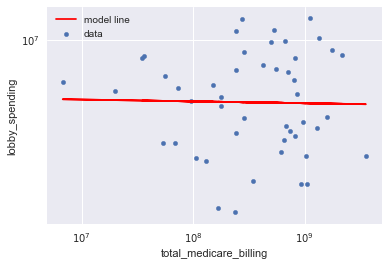

In [36]:
#scatter plot
ax = pharma_medicare_plus_lobby.plot(x = 'total_medicare_billing', y = 'lobby_spending', kind = 'scatter', loglog=True,\
                                     label='data')
plot_range = np.linspace(pharma_medicare_plus_lobby.log_total_medicare_billing.min(), \
                         pharma_medicare_plus_lobby.log_total_medicare_billing.max(), 1000)
#predicted = linmodel.predict(plot_range)
ax.plot(pharma_medicare_plus_lobby['total_medicare_billing'], 10**(linmodel.predict()), c='r', label='model line')
#ax.plot(plot_range, predicted, c='r', label='model line')
ax.legend()